## Setup

In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


Initially this returns a dataset of (text, label pairs):

In [3]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/gjl0z298kxs3n78e1mj9l/training_data_companydata_adjusted_by_keywords.csv?rlkey=gfexpgeo6hrybtn9un2r2t399&dl=1')
df = df.groupby('text').max().reset_index()

print('10 random samples:')
display(df.sample(10))

stakeholder = 'CUS'
df['label'] = df[stakeholder]
df = df[['text', 'label']].groupby('text').max().reset_index()

print('labels:')
print(df['label'].value_counts())

10 random samples:


,text,performance,CUS,INV,EMP,SOC
2359,"Further, for loans not otherwise reportable as...",0,0,0,0,0
3027,In the period of time that elapses between the...,1,0,1,0,0
473,We may also experience operational disrupti...,1,0,0,1,0
3772,Our managed funds are investment companies und...,0,0,0,0,0
1758,Credit requests exceeding individual authority...,0,0,0,0,0
6477,our ability to continually secure new business...,0,0,0,0,0
922,An increase of $72 million in OTTI losses was ...,0,0,0,0,0
1958,Due to the timing of our prior reclassificatio...,0,0,0,0,0
4584,The Firm does not consolidate residential mort...,0,0,0,0,0
3462,Net investment income was $230 million in 2019...,1,0,1,0,0


labels:
0    5910
1     654
Name: label, dtype: int64


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
!mkdir knowledge_data
!mkdir knowledge_data/neg
!mkdir knowledge_data/pos

In [6]:
for i in df[df['label']==0].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/neg/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()
for i in df[df['label']==1].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/pos/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6564 files belonging to 2 classes.
Using 5252 files for training.
Found 6564 files belonging to 2 classes.
Using 1312 files for validation.


In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'The Bank or the Company is, or has been, defending a number of putative class actions alleging claims under the federal Telephone Consumer Protection Act as a result of phone calls made by the Bank.'
 b'Generally, daily changes in the level of Citis secured funding are primarily due to fluctuations in secured lending activity in the matched book (as described below) and securities inventory'
 b'Group long-term disability provides employees with insurance coverage for loss of income in the event of extended work absences due to sickness or injury.']

labels:  [0 0 0]


In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'in', 'a', 'or', 'our',
       'as', 'due', 'for', 'are', 'that', 'result', 'may', 'we', 'on',
       'from'], dtype='<U15')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 154,   8,   2,  50,  20,   8,  85, 144,   1,   7, 228,   3,
          1,   1, 325,   1, 145,  68,   2, 206,   1, 437, 762, 283,  10,
          7,  15,   3,   1,   1, 310,  21,   2, 154,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [150,   1,  34,   6,   2, 133,   3,   1,   1, 354,  13,  49,  11,
          4, 391,   6,   1, 536, 266,   6,   2,   1,   1,  10, 586, 523,
          5,  64,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [388, 335, 558, 749, 282,  24, 104, 781,  12,  65

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'The Bank or the Company is, or has been, defending a number of putative class actions alleging claims under the federal Telephone Consumer Protection Act as a result of phone calls made by the Bank.'
Round-trip:  the bank or the company is or has been [UNK] a number of [UNK] [UNK] actions [UNK] claims under the federal [UNK] consumer protection act as a result of [UNK] [UNK] made by the bank                                                

Original:  b'Generally, daily changes in the level of Citis secured funding are primarily due to fluctuations in secured lending activity in the matched book (as described below) and securities inventory'
Round-trip:  generally [UNK] changes in the level of [UNK] [UNK] funding are primarily due to fluctuations in [UNK] lending activity in the [UNK] [UNK] as described below and securities [UNK]                                                      

Original:  b'Group long-term disability provides employees with insurance coverage for loss

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

accuracy = tf.metrics.BinaryAccuracy()
recall = tf.metrics.Recall()
precision = tf.metrics.Precision()
metrics = [accuracy, recall, precision]

In [16]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 45s 174ms/step - loss: 0.4972 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3107 - val_binary_accuracy: 0.9135 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 25s 152ms/step - loss: 0.3190 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3011 - val_binary_accuracy: 0.9031 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 27s 166ms/step - loss: 0.2811 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2542 - val_binary_accuracy: 0.9062 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 26s 155ms/step - loss: 0.2342 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2324 - val_binary_accuracy: 0.8979 - val_recall: 0.0000e+00 

In [18]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 2s 38ms/step - loss: 0.1667 - binary_accuracy: 0.9543 - recall: 0.5789 - precision: 0.9506
Loss: 0.16671320796012878
Accuracy: 0.9542682766914368
Recall: 0.5789473652839661
Precision: 0.9506173133850098
F1: 0.7196261742347418


In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])


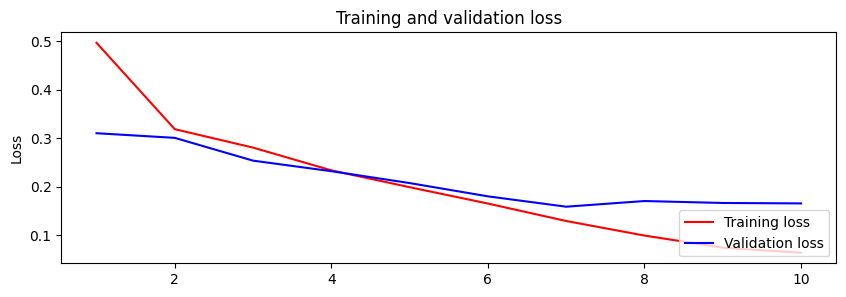

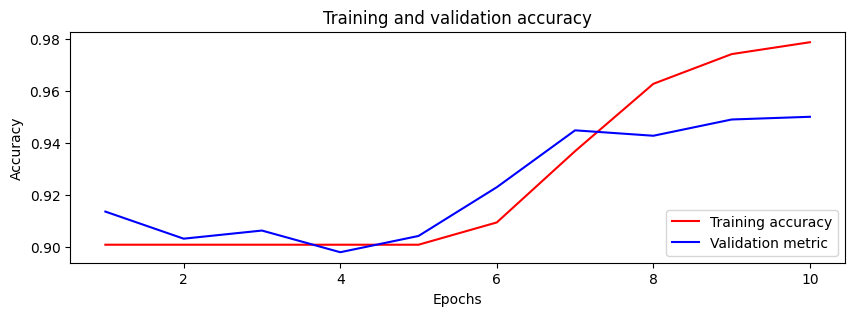

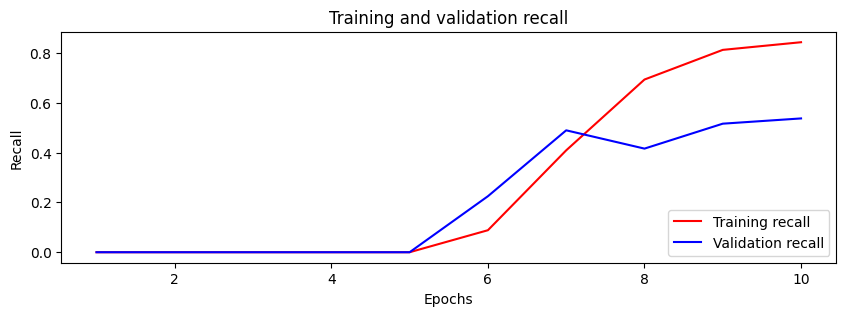

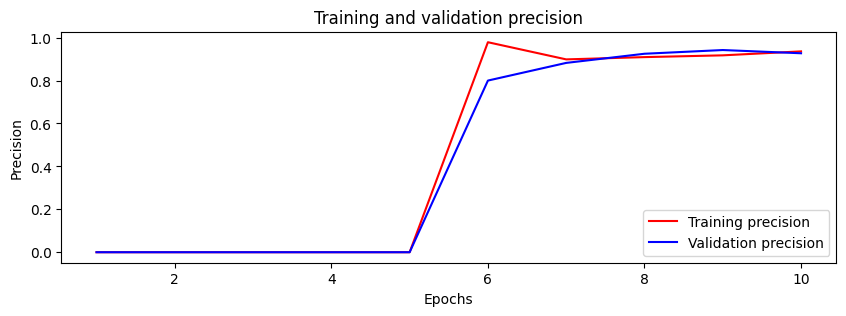

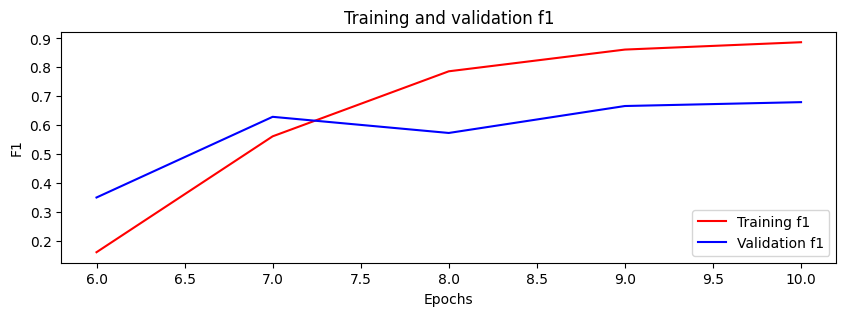

In [20]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('Bank of America hit with $250M in fines and refunds for double-dipping fees and fake accounts.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 3s 3s/step


array([[-2.9452434]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 71s 322ms/step - loss: 0.4794 - binary_accuracy: 0.9115 - recall: 0.1177 - precision: 0.9506 - val_loss: 0.3159 - val_binary_accuracy: 0.9073 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 46s 282ms/step - loss: 0.3323 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2989 - val_binary_accuracy: 0.9073 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
165/165 [==============================] - 48s 290ms/step - loss: 0.2956 - binary_accuracy: 0.9008 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2392 - val_binary_accuracy: 0.9073 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
165/165 [==============================] - 46s 279ms/step - loss: 0.2084 - binary_accuracy: 0.9031 - recall: 0.0230 - precision: 1.0000 - val_loss: 0.1794 - val_binary_accuracy: 0.9115 - val_recall: 0.0449 - val_precision: 1.0

In [25]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 3s 77ms/step - loss: 0.1489 - binary_accuracy: 0.9642 - recall: 0.7218 - precision: 0.9057
Loss: 0.14887557923793793
Accuracy: 0.9641768336296082
Recall: 0.7218044996261597
Precision: 0.9056603908538818
F1: 0.8033472784272456


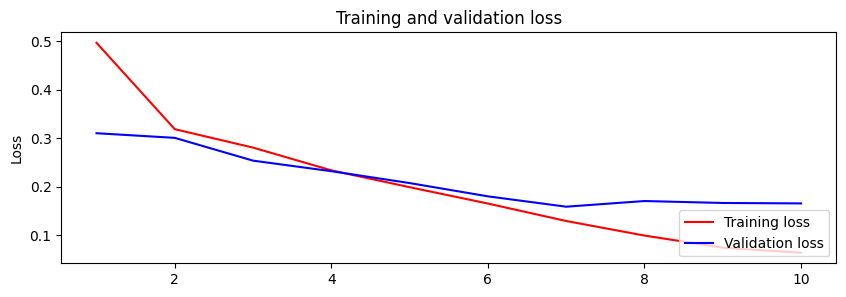

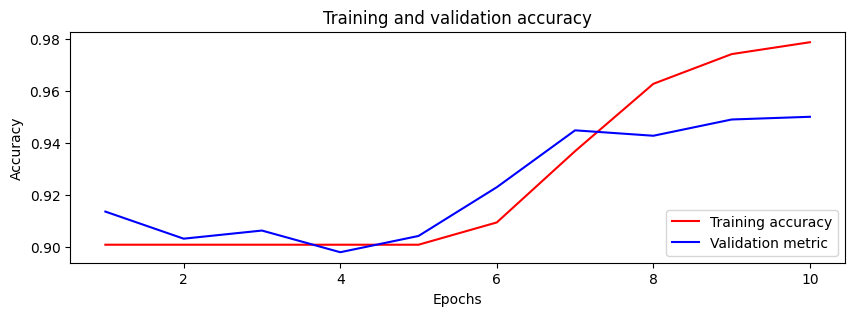

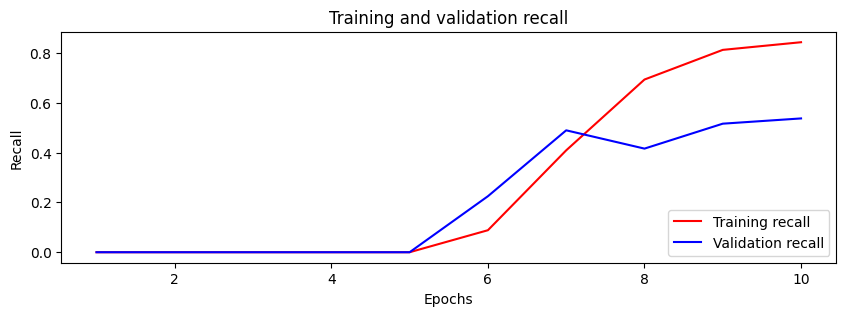

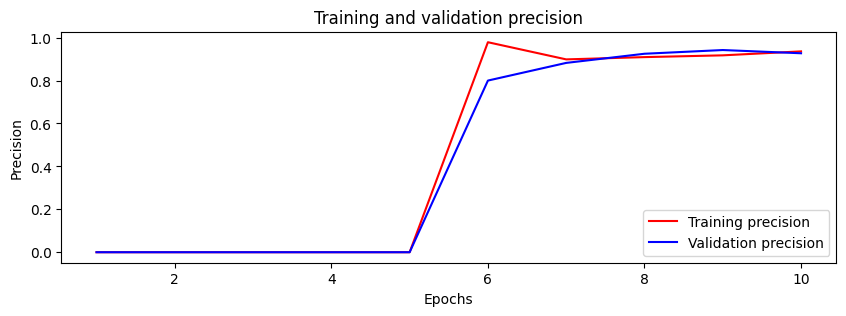

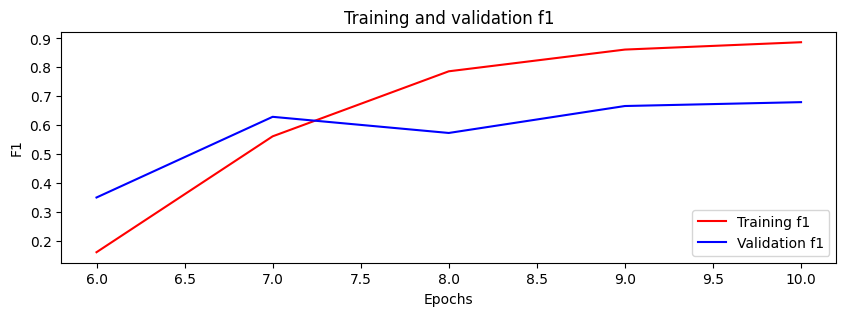

In [26]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()